# Esercizio 4
In questo esercizio si utilizzano diverse tecniche Monte Carlo per il calcolo di un integrale. Sono messe a confronto le tecniche di crude MC, hit or miss e due tecniche per ridurre la varianza del calcolo. 

In [42]:
from numba import jit, float64
import numpy as np
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import *
# matplotlib settings
mpl.rc('axes', titlesize=18)
mpl.rc('axes', labelsize=18)
mpl.rc('axes', grid=True)
mpl.rc('grid', linestyle=':')
mpl.rc('legend', fontsize=20)
mpl.rc('figure', figsize=(14, 11))
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)

In [3]:
@jit
def f(x):
    return x**5 + x**4

vf = np.vectorize(f)

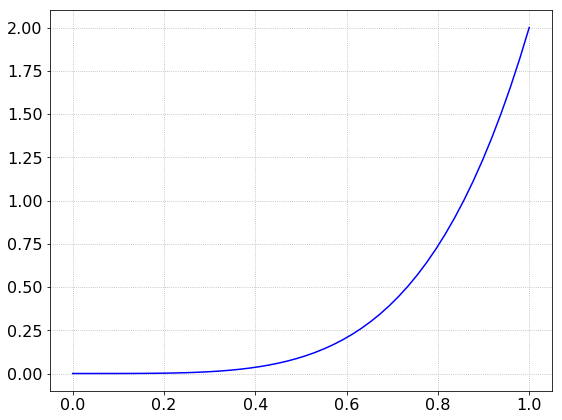

In [4]:
x = np.linspace(0,1)
y = f(x)
plt.figure(figsize=(9,7))
plt.plot(x, y, 'b')
plt.show()

## Integrazione Crude Montecarlo


Si calcola il valore di aspettazione della funzione $y(x)$ data la p.d.f. uniforme nell'intervallo $(a,b)$. 
\begin{equation}
\mu_y = E[y] = \frac{1}{b-a} \int_a^b y(x) dx = \frac{I}{b-a}
\end{equation}
La varianza della funzione y(x) applicata a una distribuzine uniforme è:
\begin{equation}
\sigma_y^2 = V[y] = \frac{1}{b-a} \int_a^b (y-\mu_y)^2 dx = \frac{1}{b-a}\int_a^by^2dx - \mu_y^2 
\end{equation}
Siano $y_i = y(x_i)$ con $x_i$ distributi uniformemente: per il teorema del limite centrale la media di $n$ valori $y_i$ tenderà a una distribuzione gaussiana con media $I/(b-a)$ e varianza $\sigma_y / \sqrt{n}$. 
Si generano quindi $n$ valori $x_i$ distribuiti uniformemente in $(a,b)$ e si calcolano $y_i$ e $y_i^2$. Si ottiene quindi la stima dell'integrale come: 

\begin{equation}
I = \int_{a}^b y(x) dx = (b-a)\left( \bar{y} \pm \frac{1}{\sqrt{n}} \sqrt{\bar{y^2} - \bar{y}^2} \right)
\end{equation}

La varianza di questo metodo è data da $\frac{1}{\sqrt{n}}$.


In [5]:
@jit
def calculate_crude_mc(a, b , N):
    x = np.random.uniform(a, b, N)
    y = vf(x)
    ymean = np.mean(y)
    ysquare = np.power(y, 2)
    integral = (b-a)*ymean
    variance = (1/ sqrt(N))* sqrt(np.mean(ysquare) - ymean**2)
    return integral, variance

In [6]:
results = []
# Si eseguono tentativi con N distribuito su scala logaritmica
Ns = np.logspace(2, 7, 40, dtype=np.int32)
for N in Ns:
    results.append(calculate_crude_mc( 0., 1., N))
    
results_crude = np.array(results)

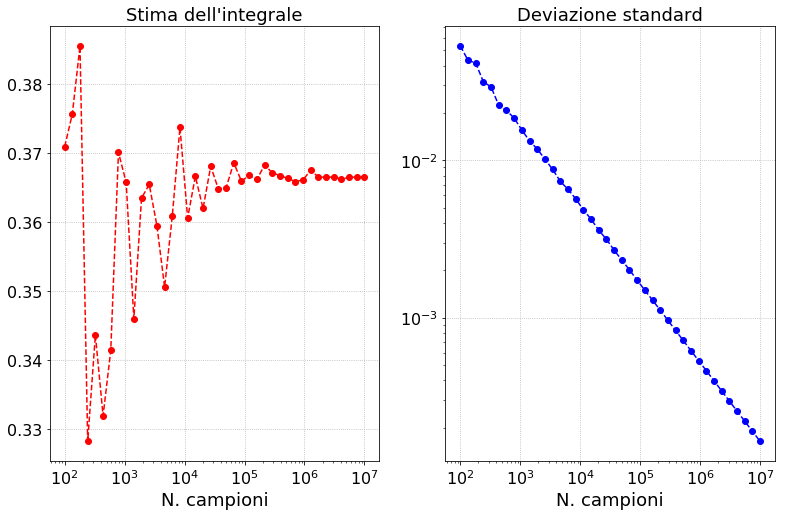

In [43]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(13, 8))
ax1.semilogx(Ns, results_crude[:,0], 'ro--')
ax1.set_title("Stima dell'integrale")
ax1.set_xlabel("N. campioni")
ax2.loglog(Ns, results_crude[:,1], 'bo--' )
ax2.set_title("Deviazione standard")
ax2.set_xlabel("N. campioni")
plt.show()

In [55]:
print(results_crude[-1:])

[[3.66615021e-01 1.63545014e-04]]


## Hit or miss
Questa tecnica consiste nel generare un punto nel quadrato definito dagli estremi di integrazione e dal massimo e minimo della funzione $y(x)$. 
\begin{align}
x_i &= R[a,b]\\y_i &= R[y_{min}, y_{max}]
\end{align}
Per ogni punto generator si confronta $y(x_i)$ con la $y_i$ generata. Se $y_i < y(x_i)$ si conta un \emph{hit}.
La stima dell'integrale è la frazione di hit ottenuta:
\begin{equation}
I = \frac{n_{hits}}{n}(b-a)(y_{max} - y_{min}) +y_{min}(b-a)
\end{equation}
La varianza di questo metodo si calcola considerano il processo di hit or miss un processo binomiale con $E[n_{hits}]=np$ e varianza $V[n_{hit}]=np(1-p)$. 
\begin{equation}
\sigma_I = \frac{\sqrt{n_{hits}}}{n} \sqrt{\left(1-\frac{n_{hits}}{n}\right)} (b-a)(y_{max}- y_{min})
\end{equation}
Anche la varianza di questo metodo va come $\frac{1}{\sqrt{n}}$ ma generalmente è maggiore in valore assoluto della varianza del crude MC.

In [8]:
@jit
def calculate_hit_or_miss(a, b, ymin,ymax, N):
    x = np.random.uniform(a, b, N)
    y = np.random.uniform(ymin, ymax, N)
    fx = vf(x)
    hits = y[y < fx].size
    integral = (hits/N)*(b-a)*(ymax-ymin) + ymin*(b-a)
    variance = (sqrt(hits)/N)*sqrt(1- (hits/N)) *(b-a)*(ymax-ymin)
    return integral, variance   

In [9]:
results = []
Ns = np.logspace(2, 7, 40, dtype=np.int32)
for N in Ns:
    results.append(calculate_hit_or_miss( 0., 1., 0., 2., N))
    
results_hit = np.array(results)

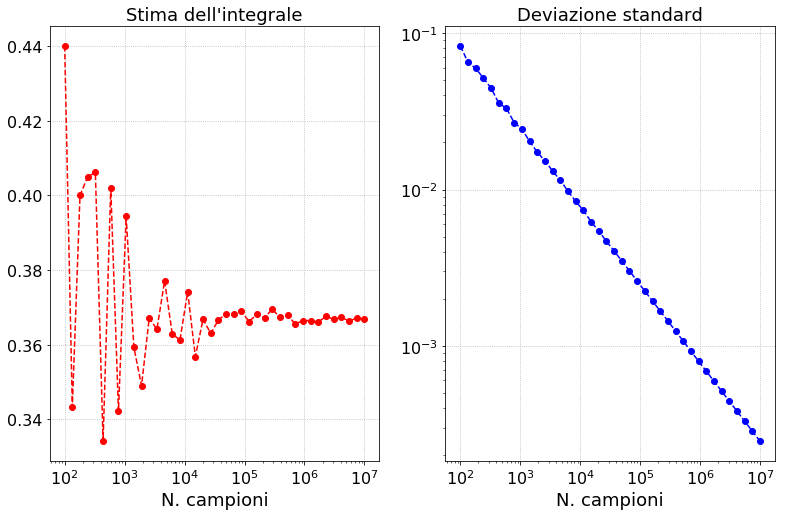

In [45]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(13, 8))
ax1.semilogx(Ns, results_hit[:,0], 'ro--')
ax1.set_title("Stima dell'integrale")
ax1.set_xlabel("N. campioni")
ax2.loglog(Ns, results_hit[:,1], 'bo--' )
ax2.set_title("Deviazione standard")
ax2.set_xlabel("N. campioni")
plt.show()

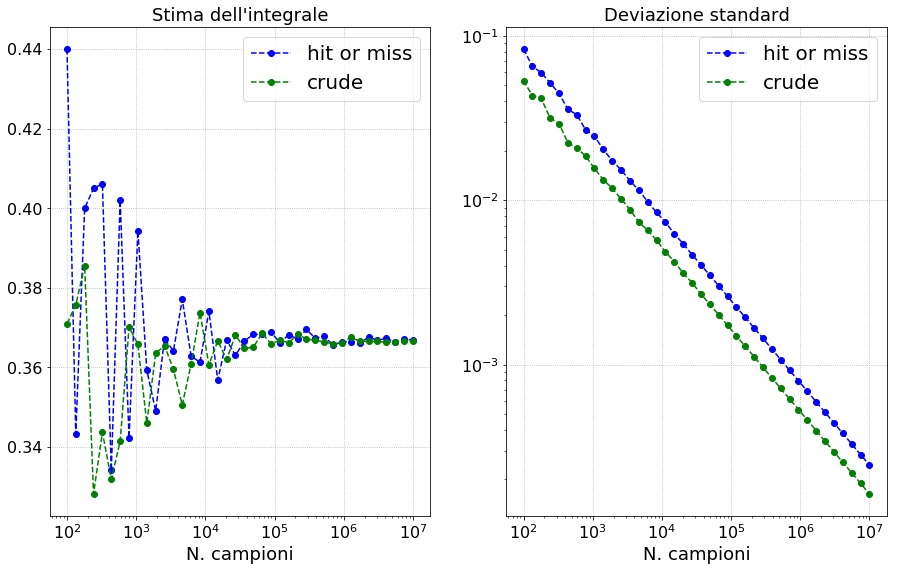

In [47]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(15, 9))
ax1.semilogx(Ns, results_hit[:,0], 'bo--', label="hit or miss")
ax1.semilogx(Ns, results_crude[:,0], 'go--', label="crude")
ax1.legend()
ax1.set_title("Stima dell'integrale")
ax1.set_xlabel("N. campioni")
ax2.loglog(Ns, results_hit[:,1], 'bo--', label="hit or miss")
ax2.loglog(Ns, results_crude[:,1] , 'go--', label="crude")
ax2.legend()
ax2.set_title("Deviazione standard")
ax2.set_xlabel("N. campioni")
plt.show()

## Tecniche di riduzione della varianza
### Stratification
Queste approccio consiste nel suddividere l'integrale in diverse regioni e di calcolarlo separatamente in ognuna di esse. L'integrale finale è la somma degli integrali e la varianza è la somma delle varianze. Una buona scelta delle regioni può migliorare di molto la varianza, soprattutto se si riesce a suddividere il dominio della funzioni in zone dove essa è più uniforme. 


In [49]:
@jit
def stratification(a, b, n_divisions, N):
    intervals = np.append(np.arange(a, b, (b-a)/n_divisions), b)
    results = []
    for i in range(n_divisions):
        #print(intervals[i], intervals[i+1], int(N / n_divisions))
        results.append(calculate_crude_mc(intervals[i], intervals[i+1], int(N / n_divisions)))
    results = np.array(results)
    variance = np.sqrt(np.sum(np.power(results[:, 1], 2), axis=0))
    return np.sum(results, axis=0)[0], variance

Si suddivide quindi il dominio di integrazione da 2 a 20 volte, mantenendo un numero di tentativi complessivo di $10^7$. 
Come si osserva nel grafico della deviazione standard per ogni suddivisione, la varianza aumenta e non diminuisce mai. Questo fatto è giustificato dalla forma della funzione tra $(0,1)$, sempre crescente: non è possibile suddividere l'integrale in zone dove la funzione è più uniforme quindi il metodo della stratificazione non è efficace. 

In [50]:
results = []
divisions = np.linspace(1,20,20, dtype= np.int32)
for d in divisions:
    r = stratification(0., 1., d, 1e7)
    results.append(r)
    print(d, r)
results = np.array(results)

1 (0.3665847016399106, 0.00016353117890966835)
2 (0.366608923427892, 0.00024153216590870198)
3 (0.3664525919900555, 0.00026652374977935466)
4 (0.3668615567981857, 0.0002765535205644812)
5 (0.3665783944794792, 0.0002809997326140471)
6 (0.36664471222880557, 0.0002836159895029416)
7 (0.3667165026584127, 0.0002852477842075049)
8 (0.366663408140393, 0.00028626061667491235)
9 (0.36669521064529054, 0.00028699416296517716)
10 (0.36672146539459227, 0.000287408922355878)
11 (0.3666829439593161, 0.0002877844793395462)
12 (0.3666502238957399, 0.0002879682035384756)
13 (0.3666637445836235, 0.000288301236107462)
14 (0.3666542512223183, 0.0002884710453165889)
15 (0.36664287549275987, 0.0002884793195325745)
16 (0.3666613141893819, 0.00028877759319308264)
17 (0.3666885428261581, 0.00028877597980702735)
18 (0.3667003123729492, 0.00028888616414586777)
19 (0.3666691579927025, 0.00028899760114027876)
20 (0.3666541077381165, 0.00028898098300611345)


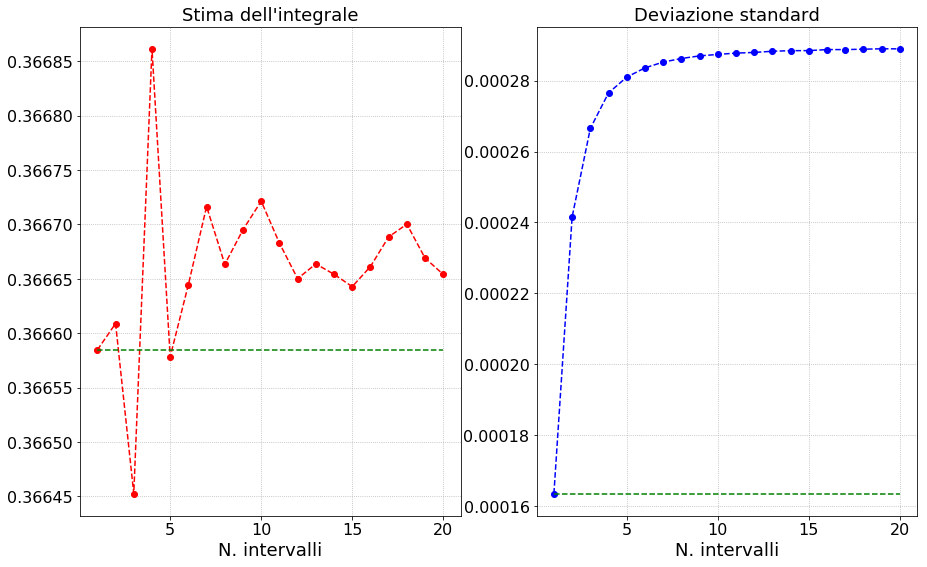

In [52]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(15, 9))
ax1.plot(divisions, results[:,0], 'ro--')
ax1.set_title("Stima dell'integrale")
ax1.set_xlabel("N. intervalli")
ax1.plot(divisions, [results[0][0]]*len(divisions), 'g--')
ax2.plot(divisions, results[:,1], 'bo--' )
ax2.plot(divisions, [results[0][1]]*len(divisions), 'g--')
ax2.set_title("Deviazione standard")
ax2.set_xlabel("N. intervalli")
plt.show() 

In [24]:
first= calculate_crude_mc(0, 0.88, int(6e6))
second = calculate_crude_mc(0.88, 1, int(4e6))
print(first)
print(second)
var= np.array([first[1], second[1]])
final_var = np.sqrt(np.sum(np.power(var, 2)))
print("integral:{}\nVariance:{}".format(first[0]+ second[0], final_var))
print(calculate_crude_mc(0, 1, int(1e7)))

(0.18284790725689107, 0.00011925183125473929)
(0.18372333412772662, 0.0001258615231155639)
integral:0.3665712413846177
Variance:0.0001733843195291271
(0.3663850319357653, 0.0001634894133989901)


### Importance sampling
La varianze della crude MC integration è legata alla varianza delle funzione $y(x)$ che viene integrata.
Per ridurre questo effetto si può utilizzare la tecnica dell'importance sampling che costituisce nell'utilizzare un campionamento più fitto nelle regioni di interesse dalla funzione. 

Per utilizzare questo metodo è necessario trovare una p.d.f. $g(x)$ (normalizzata in $(a,b)$) tale che $y(x)/g(x)$ è il più costante possibile all'interno della regione di integrazione. Si procede quindi con un cambio di variabili:

\begin{equation}
I = \int_a^b y(x) dx = \int_a^b \frac{y(x)}{g(x)}g(x)dx = \int_{G(a)}^{G(b)}\frac{y(x)}{g(x)} dG(x) 
\\ \text{con}\;G(X) = \int_a^b g(x) dx
\end{equation}
E' necessario sapere generare numeri distribuiti come $g(x)$, quindi si calcola l'integrale sommando $y(x)/g(x)$ con $x$ campionato secondo $g(x)$. 

Per applicare questa tecnica sulla funzione in esame in questo esercizio si è utilizzata la p.d.f. normalizzata tra $(0,1)$:
\begin{equation}
   g(x) = 5 x^4
\end{equation}

In [26]:
@jit
def invG(y):
    return np.power(y, 0.2)

@jit
def g(x):
    return 5 * np.power(x, 4)

In [28]:
@jit
def calculate_importance_sampling(a, b , N):
    unif = np.random.uniform(0,1, N)
    x = invG(unif)
    gx = g(x)
    yfunction = vf(x)
    y = yfunction/ gx
    ymean = np.mean(y)
    ysquare = np.power(y, 2)
    integral = (b-a)*ymean
    variance = (1/ sqrt(N))* sqrt(np.mean(ysquare) - ymean**2)
    return integral, variance

In [29]:
results = []
Ns = np.logspace(2, 7, 40, dtype=np.int32)
for N in Ns:
    results.append(calculate_importance_sampling(0., 1., N))
    
results_sampling = np.array(results)

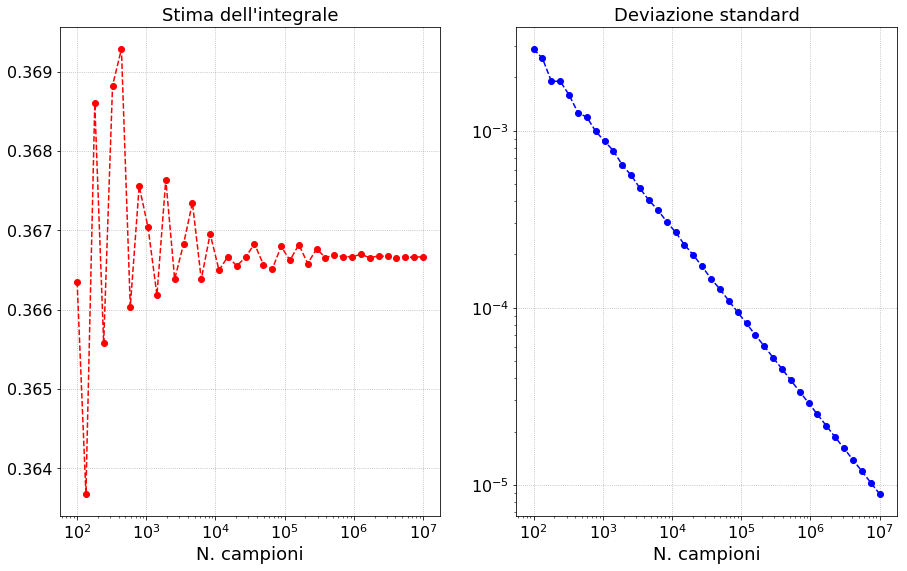

In [53]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 9))
ax1.semilogx(Ns, results_sampling[:,0], 'ro--')
ax1.set_title("Stima dell'integrale")
ax1.set_xlabel("N. campioni")
ax2.loglog(Ns, results_sampling[:,1], 'bo--' )
ax2.set_title("Deviazione standard")
ax2.set_xlabel("N. campioni")
plt.show()

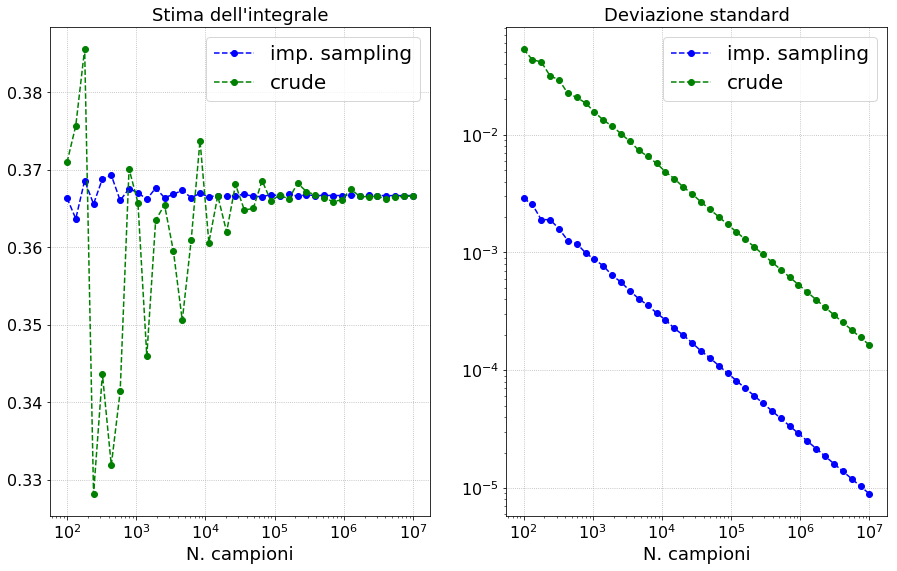

In [54]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(15, 9))
ax1.semilogx(Ns, results_sampling[:,0], 'bo--', label="imp. sampling")
ax1.semilogx(Ns, results_crude[:,0], 'go--', label="crude")
ax1.legend()
ax1.set_title("Stima dell'integrale")
ax1.set_xlabel("N. campioni")
ax2.loglog(Ns, results_sampling[:,1], 'bo--', label="imp. sampling")
ax2.loglog(Ns, results_crude[:,1] , 'go--', label="crude")
ax2.legend()
ax2.set_title("Deviazione standard")
ax2.set_xlabel("N. campioni")
plt.show()

Si nota che l'integrale convenge molto più velocemente che con il crude M e la varianza è circa un ordine di grandezza inferiore. 